# Aggregation of water masks

In [1]:
import io
import rasterio
import requests
import zipfile
import numpy as np
from pathlib import Path
from rasterio.plot import show

In [2]:
# /!\ Please enter the right location
DATA_DIR = "./"# /!\ Change directory if you want
# Local execution
OUTPUT_DIR = "./"# /!\ Change directory if you want

In [3]:
zip_file_url = "https://www.orfeo-toolbox.org/packages/WorkshopData/data_otb-guided-tour.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(DATA_DIR)

In [4]:
s2_20180621 = Path(DATA_DIR) / "data" / "xt_SENTINEL2B_20180621-111349-432_L2A_T30TWT_D_V1-8_RVBPIR.tif"
s2_20180701 = Path(DATA_DIR) / "data" / "xt_SENTINEL2B_20180701-111103-470_L2A_T30TWT_D_V1-8_RVBPIR.tif"
s2_20180706 = Path(DATA_DIR) / "data" / "xt_SENTINEL2A_20180706-110918-241_L2A_T30TWT_D_V1-8_RVBPIR.tif"
s2_20180711 = Path(DATA_DIR) / "data" / "xt_SENTINEL2B_20180711-111139-550_L2A_T30TWT_D_V1-8_RVBPIR.tif"

input data shape : (4, 2080, 2410) (bands, height, width)


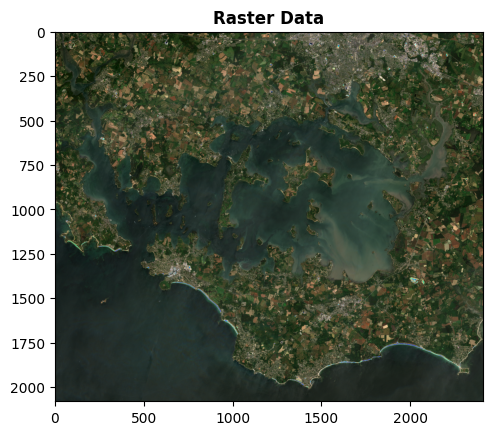

In [5]:
def show_raster(input_image:str):
    with rasterio.open(input_image) as src:
        # get the RGB bands
        raster_data = src.read()
        print(f"input data shape : {raster_data.shape} (bands, height, width)")
        raster_data = raster_data[0:3,:,:]

        # create new range values for visualization purpose
        flat_array = raster_data.flatten()        
        lower_bound = np.quantile(flat_array, 0.001)
        upper_bound = np.quantile(flat_array, 0.999)
        mask = (raster_data >= lower_bound) & (raster_data <= upper_bound)
        filtered_array = np.where(mask, raster_data, 0)
        min_val = filtered_array.min()
        max_val = filtered_array.max()
        rescaled_array = (filtered_array - min_val) / (max_val - min_val) * 255

        show(rescaled_array.astype(np.uint8), title="Raster Data")
        
show_raster(s2_20180621)

Compute water mask aggregation...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 22.79it/s]


input data shape : (4, 2080, 2410) (bands, height, width)


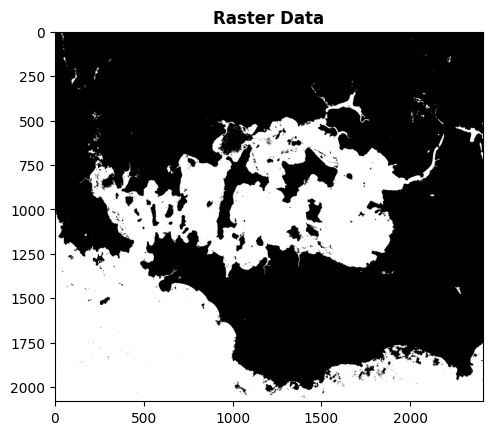

In [10]:
from typing import List

from functools import reduce

from eoscale.core.manager import EOContextManager
from eoscale.core.eo_executors import n_images_to_m_images_filter



def ndwi_filter(input_buffers: list,
               input_profiles: list,
               params: dict) -> List[np.ndarray]:
    eps = 0.001
    return [(input_buffer[1] - input_buffer[3]) / (input_buffer[1] + input_buffer[3] + eps) for input_buffer in input_buffers]


def copy_profile(input_profiles: list,
                 params: dict) -> dict:
    return input_profiles

    
def compute_ndwi(context: EOContextManager, input_files: List[str]):
    """
    Compute NDWI on a single Sentinel-2 image
    """
    return n_images_to_m_images_filter(inputs=[eoscale_manager.open_raster(input_file) for input_file in input_files],
                                       image_filter=ndwi_filter,
                                       generate_output_profiles=copy_profile,
                                       context_manager=context,
                                       filter_desc="Compute NDWI...")

def water_mask_filter(input_buffers: list,
               input_profiles: list,
               params: dict) -> List[np.ndarray]:
    return [np.where(input_buffer > params["ndwi_threshold"], True, False).astype(bool) for input_buffer in input_buffers]

    
def water_mask(context: EOContextManager, input_files: str, ndwi_threshold: float):
    """
    Compute a water mask using threshold, 1 mean water 0 otherwise
    """
    return n_images_to_m_images_filter(inputs=input_files,
                                       image_filter=water_mask_filter,
                                       filter_parameters = {"ndwi_threshold":ndwi_threshold},
                                       generate_output_profiles=copy_profile,
                                       context_manager=context,
                                       filter_desc="Compute water mask...")


def water_mask_aggregation_profile(input_profiles: list,
                 params: dict) -> dict:
    return input_profiles[0]


def water_mask_aggregation_filter(input_buffers: list,
               input_profiles: list,
               params: dict) -> List[np.ndarray]:
    return [reduce(np.logical_and, input_buffers)]


def water_mask_aggregation(context: EOContextManager, input_files: str):
    """
    Compute a water mask using threshold, 1 mean water 0 otherwise
    """
    return n_images_to_m_images_filter(inputs=input_files,
                                       image_filter=water_mask_aggregation_filter,
                                       generate_output_profiles=water_mask_aggregation_profile,
                                       context_manager=context,
                                       filter_desc="Compute water mask aggregation...")
    
s2_20180621_water_mask = Path(OUTPUT_DIR) / "s2_20180621_water_mask.tif"
water_mask_agg = Path(OUTPUT_DIR) / "water_mask_agg.tif"
with EOContextManager(nb_workers = 2, tile_mode = True) as eoscale_manager:
    ndwi_keys = compute_ndwi(eoscale_manager, [s2_20180621, s2_20180701, s2_20180706, s2_20180711])
    water_mask_keys = water_mask(eoscale_manager, ndwi_keys, 0)
    water_mask_aggregation_keys = water_mask_aggregation(eoscale_manager, water_mask_keys)
    eoscale_manager.write(water_mask_aggregation_keys[0], str(water_mask_agg))
show_raster(water_mask_agg)